## Logoplots
Motif sequence analysis is a crucial analysis step and is often executed through generation of logoplots with respective tools. Here, we represent a *Scirpy* native wrapper function `scirpy.pl.logoplot_cdr3_motif` to a well established python package called [logomaker](https://logomaker.readthedocs.io/en/latest/index.html). With `to_type` we can specify, how  the logoplot is calculated and `plot_default`offers a convenient "pre-styling" that can be easily adapted. As logomaker offers a lot of further customization opportunities and `scirpy.pl.logoplot_cdr3_motif`, will allow any input that is accepted by logomaker we suggest to head to their [documentation](https://logomaker.readthedocs.io/en/latest/implementation.html#logo-class) to maximize the use of this amazing package.

:::{note}
The input to 
`scirpy.pl.logoplot_cdr3_motif` is expected to include only sequences that have the same junction length, because it is not possible to perform multiple sequence alignment with *Scirpy*. Therefore, the user has to manually filter the MuData object prior or while the function call.
:::

The logoplot below shows the likelihood of any amino acid to occur among expanded clonotype clusters with a spectratype of 20. 

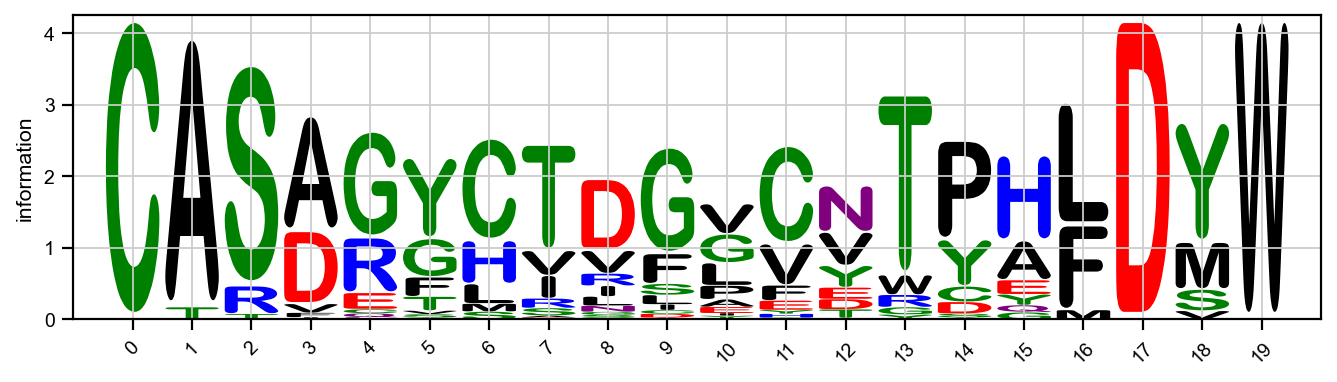

In [61]:
with ir.get.obs_context(
    mdata["airr"], {"junction_len": [len(a) for a in ir.get.airr(mdata, "junction_aa", "VDJ_1")]}
) as m:
    ir.pl.logoplot_cdr3_motif(
        m[(m.obs["junction_len"] == 20) & (m.obs["clonal_expansion"].isin(["<= 2", "> 2"]))],
        chains=["VDJ_1"],
        plot_default=True,
        to_type="information",
    )

The next logoplot is similar to the previous one, but should demonstrate that it is very easy to generate logoplots of certain clonotype clusters, as they always have the same junction length due to the nature of the used hamming distance. As expected there is only small variation inside the same clonotype cluster, but interestingly position 10 and 12 differs the most.

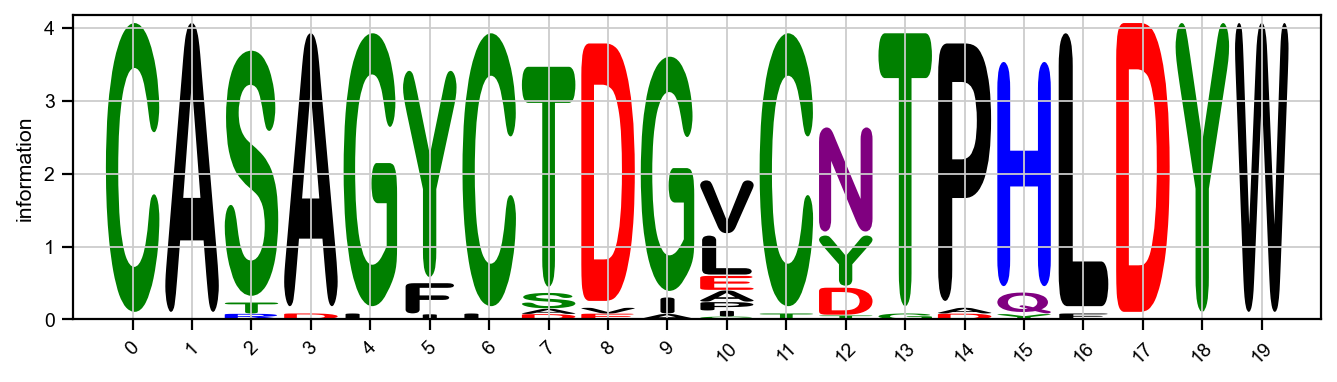

In [63]:
ir.pl.logoplot_cdr3_motif(
    mdata[mdata.obs["airr:clone_id_85_similarity"] == "2707"],
    chains=["VDJ_1"],
    plot_default=True,
    to_type="information",
)